In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py

os.chdir('/content')
print("Current working directory", os.getcwd())

--2023-11-15 13:31:43--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15061 (15K) [text/plain]
Saving to: ‘models.py.2’

models.py.2         100%[===================>]  14.71K  --.-KB/s    in 0s      

2023-11-15 13:31:43 (84.6 MB/s) - ‘models.py.2’ saved [15061/15061]

--2023-11-15 13:31:43--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7280 (7.1K) [text/plain]


In [4]:
from utils import vision
from utils import utils
from utils import losses

In [5]:
experiment = {
    'TYPE': 'train',        # Experiment type: 'train', 'test'
    'ACCELERATOR': 'GPU',   # 'CPU', 'GPU' or 'TPU'

    'IMAGE_SIZE': (512, 512),
    'INPUT_SHAPE': (512, 512, 3),
    'VALID_SIZE': 0.1,      # Validation data size: (Valid Data) / (All Data)
    'DATA_AUG': True,       # Apply data augmentation

    'BACKBONE': 'custom',        # 'custom', 'VGG16', 'VGG19' - default 'custom'
    'LAST_TRANIABLE_LAYERS': 5,  # number of last trainable layers of pre-trained backbone models, fine-tuning
    'BATCH_SIZE': 8,            # IF TPU is active set 4, otherwise set anything
    'EPOCHS': 1000,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 1e-4,

    'RECONS_LOSS': 'PERCEPTUAL',  # Reconstruction loss ('SSIM', 'MSE', 'MAE', 'PERCEPTUAL')
    'PERCEPTUAL_LAYERS': [5,8,13,18],    # [5,8,13,18], None
    'PERCEP_LOSS_MODEL': 'VGG19', # custom', 'VGG16', 'VGG19' - default 'VGG16'
    'PERP_LOSS_LAMBDA': 1,
    'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value
    'MSE_LOSS_LAMBDA': 0.01,  # MSE coeff

    # set the dimensionality of the latent space to a plane for visualization later
    'LATENT_DIM': 500,

    'SAVE_WEIGHTS_PER_EPOCH': 10,
    # Record directory of model's trained weights
    'TRAINING_WEIGHT_DIR': "autoencoder_model/BD67_dataset/training_weights",
    # Record directory of generated images
    'IMGS_DIR': "autoencoder_model/BD67_dataset/images",
}

In [6]:
import os

ROOT_PATH = '/content'
DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset'
BD67_NORMAL_PATH = os.path.join(DATASET_PATH, 'defect_free')
BD67_NORMAL_FRONT_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/cropped')
BD67_NORMAL_FRONT_ROTATED_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/rotated_images/cropped')
BD67_NORMAL_REAR_PATH = os.path.join(DATASET_PATH, 'defect_free/Rear')
BD67_DEFECTED_FRONT_PATH = os.path.join(DATASET_PATH, 'defected/Front/cropped')
BD67_DEFECTED_REAR_PATH = os.path.join(DATASET_PATH, 'defected/Rear')

In [7]:
img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_PATH, 'png')
rotated_img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_ROTATED_PATH, 'png')
all_img_files = img_files + rotated_img_files

print("Number of flat image files: ", len(img_files))
print("Number of rotated image files: ", len(rotated_img_files))
print("Number of all image files: ", len(all_img_files))

Number of flat image files:  110
Number of rotated image files:  105
Number of all image files:  215


In [8]:
train_dataset = utils.create_dataset_pipeline(img_files, batch_size=experiment['BATCH_SIZE'], img_size=experiment['IMAGE_SIZE'], scl=True, shuffle=False, num_channels=3, rot=utils.ROT_0, duplicate=True, aug_layer=None, data_aug_power=1, accelerator='GPU')

In [9]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None))>

Load Fashion MNIST Dataset

In [10]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#x_train = x_train[..., tf.newaxis]   # normally x_train.shape is (60000, 28, 28), with adding tf.newaxis we get x_train.shape as (60000, 28, 28, 1)
#x_test = x_test[..., tf.newaxis]     # normally x_test.shape is (60000, 28, 28), with adding tf.newaxis we get x_test.shape as (60000, 28, 28, 1)

x_train = tf.cast(tf.reshape(x_train, shape=(60000, 28, 28, 1)), tf.float32)
x_test = tf.cast(tf.reshape(x_test, shape=(10000, 28, 28, 1)), tf.float32)

print(x_train.shape)

(60000, 28, 28, 1)


In [11]:
filters = [32, 64, 128, 128, 256, 256, 256]

for num_filter in filters[::-1]:
  print(num_filter)

256
256
256
128
128
64
32


In [12]:
filters = [32, 64, 128, 128, 256, 256, 256]

for num_filter in filters[-2::-1]:
  print(num_filter)

256
256
128
128
64
32


In [13]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv2DTranspose, MaxPooling2D, UpSampling2D, Add
from tensorflow.keras.layers import LeakyReLU, Lambda, ReLU, Concatenate

In [14]:
class ConvAEModel(tf.keras.Model):
    def __init__(self, input_shape, latent_dim, layer_sizes=None):
        super().__init__()
        self._input_shape = input_shape
        self._latent_dim = latent_dim
        self.layer_iter = 0
        self._layer_sizes = [32, 64, 128, 128, 256, 256, 256]
        if layer_sizes != None:
          self._layer_sizes = layer_sizes
        num_strides = len(self._layer_sizes)
        self._num_dense = int(self._input_shape[0]/(2**num_strides))

        self.config_conv_blocks()
        self._model = self.create_custom_model()

        self.loss_tracker = keras.metrics.Mean(name='loss')
        self.mae_metric = keras.metrics.MeanAbsoluteError()
        #self.accuracy_metric = keras.metrics.Accuracy()
        # https://keras.io/api/metrics/

    def config_conv_blocks(self, padding='same', use_bias=True, batch_norm=True, use_leaky_relu=True, leaky_slope=0.2):
        self.padding = padding
        self.use_bias = use_bias
        self.batch_norm = batch_norm
        self.leaky_slope = leaky_slope
        self.act_func = tf.keras.layers.LeakyReLU(self.leaky_slope) if use_leaky_relu else tf.keras.layers.ReLU()

    def conv_block(self, x, filters, kernel, stride, deconv=False, name='conv_block'):
        if deconv:
          x = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=(kernel,kernel), strides=stride, padding=self.padding, use_bias=self.use_bias, name=name)(x)
        else:
          x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(kernel,kernel), strides=stride, padding=self.padding, use_bias=self.use_bias, name=name)(x)

        if self.batch_norm:
          name = 'conv_block_bacth_norm_' + str(self.layer_iter)
          x = BatchNormalization(name=name)(x)

        self.layer_iter += 1
        x = self.act_func(x)
        return x

    def summary(self):
        return self._model.summary()

    def create_custom_model(self):
        # Encoder Part
        input = keras.Input(shape=self._input_shape)
        # Conv blocks
        x = self.conv_block(input, filters=self._layer_sizes[0], kernel=5, stride=2, name='conv2d_block_0')
        for ix, num_filter in enumerate(self._layer_sizes[1:]):
          _name = 'conv2d_block_' + str((ix+1))
          x = self.conv_block(x, filters=num_filter, kernel=5, stride=2, name=_name)
        # Flatten layer
        x = Flatten(name='flatten_layer')(x)
        x = Dense(units=(self._num_dense*self._num_dense*256))(x)

        #x = BatchNormalization(name='bacth_norm_1')(x)
        x = LeakyReLU(alpha=self.leaky_slope)(x)
        # Latent vector
        x = Dense(units=self._latent_dim, name='latent_layer')(x)
        x = LeakyReLU(alpha=self.leaky_slope)(x)

        # Decoder Part
        x = Dense(units=(self._num_dense*self._num_dense*256))(x)
        #x = BatchNormalization(name='batch_norm_2')(x)
        x = LeakyReLU(alpha=self.leaky_slope)(x)

        x = tf.keras.layers.Reshape((self._num_dense,self._num_dense,256), name='reshape_latent')(x)

        # Set activation func to ReLu for Conv2dTrasnpose blocks
        self.config_conv_blocks(use_leaky_relu=False)
        for ix, num_filter in enumerate(self._layer_sizes[-2::-1]):  # Reverse layer_sizes list and remove first element of the reversed array
          _name = 'conv2d_transpose_block_' + str((ix+1))
          x = self.conv_block(x, num_filter, kernel=5, stride=2, deconv=True, name=_name)

        output = Conv2DTranspose(filters=self._input_shape[2], kernel_size=5, strides=2, padding='same',
        use_bias=True, activation='sigmoid')(x)

        return keras.models.Model(input, output, name="conv_ae_model")

    def call(self, x):
        return self._model(x, training=False)

    def compute_loss(self, y, y_pred):
        return keras.losses.mean_squared_error(y, y_pred)

    def train_step(self, data):
        #x, y = data  # Data structure depends on your model and on what you pass to fit()
        x, _ = data  # In autoencoders, the input and output are usually the same.

        with tf.GradientTape() as tape:
            y_pred = self._model(x, training=True)  # Forward pass
            # Compute custom Loss value
            loss = self.compute_loss(x, y_pred)
            # https://keras.io/api/losses/

        # Compute Gradients
        trainable_vars = self._model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the custom metrics
        self.loss_tracker.update_state(loss)
        self.mae_metric.update_state(x, y_pred)
        #self.accuracy_metric.update_state(y, y_pred)

        return {'loss': self.loss_tracker.result(), 'mae': self.mae_metric.result()}

    def test_step(self, data):
        # Unpack the data
        #x, y = data
        x, _ = data  # In autoencoders, the input and output are usually the same.

        # Compute predictions
        y_pred = self._model(x, training=False)
        # Updates the metrics tracking the loss
        valid_loss = self.compute_loss(y=x, y_pred=y_pred)

        # Update the custom metrics
        self.loss_tracker.update_state(valid_loss)
        self.mae_metric.update_state(x, y_pred)

        return {'val_loss': self.loss_tracker.result(), 'val_mae': self.mae_metric.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.loss_tracker, self.mae_metric]

In [15]:
conv_ae_model = ConvAEModel(input_shape=experiment['INPUT_SHAPE'], latent_dim=64)
conv_ae_model.summary()

Model: "conv_ae_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_block_0 (Conv2D)     (None, 256, 256, 32)         2432      ['input_1[0][0]']             
                                                                                                  
 conv_block_bacth_norm_0 (B  (None, 256, 256, 32)         128       ['conv2d_block_0[0][0]']      
 atchNormalization)                                                                               
                                                                                                  
 leaky_re_lu (LeakyReLU)     multiple                     0         ['conv_block_bacth

In [16]:
layer_sizes = [128, 128, 64, 64, 32]
conv_ae_model = ConvAEModel(input_shape=experiment['INPUT_SHAPE'], latent_dim=64, layer_sizes=layer_sizes)
conv_ae_model.summary()

Model: "conv_ae_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_block_0 (Conv2D)     (None, 256, 256, 128)        9728      ['input_2[0][0]']             
                                                                                                  
 conv_block_bacth_norm_0 (B  (None, 256, 256, 128)        512       ['conv2d_block_0[0][0]']      
 atchNormalization)                                                                               
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   multiple                     0         ['conv_block_bacth

In [ ]:
training_files, valid_files, _, _ = train_test_split(img_files, img_files, test_size=experiment['VALID_SIZE'], random_state=100)
test_images = utils.get_all_img_files_in_directory(BD67_DEFECTED_FRONT_PATH, "png")

print("Number of Training Files: ", len(training_files))
print("Number of Validation Files: ", len(valid_files))
print("Number of Test Files: ", len(test_images))

STEPS_PER_EPOCH = len(training_files) // experiment['BATCH_SIZE']  # Indicates number of batches to be trained
STEPS_PER_VAL = len(valid_files) // experiment['BATCH_SIZE']

print("\nSTEPS_PER_EPOCH: ", STEPS_PER_EPOCH)
print("STEPS_PER_VAL: ", STEPS_PER_VAL)

train_dataset_part = train_dataset.take(STEPS_PER_EPOCH)
valid_dataset_part = train_dataset.skip(STEPS_PER_EPOCH)

print("\nNumber of training batches:   ", len(train_dataset_part))
print("Number of validation batches: ", len(valid_dataset_part))

Number of Training Files:  99
Number of Validation Files:  11
Number of Test Files:  10

STEPS_PER_EPOCH:  12
STEPS_PER_VAL:  1

Number of training batches:    12
Number of validation batches:  2


All validation batches can not be included in the training

In [ ]:
'''train_dataset_part = train_dataset_part.repeat()
valid_dataset_part = valid_dataset_part.repeat()'''

'train_dataset_part = train_dataset_part.repeat()\nvalid_dataset_part = valid_dataset_part.repeat()'

In [ ]:
conv_ae_model = ConvAEModel(input_shape=experiment['INPUT_SHAPE'], latent_dim=experiment['LATENT_DIM'])

# Compile the model
conv_ae_model.compile(optimizer='adam')

# Train the model on the MNIST dataset
conv_ae_model_hist = conv_ae_model.fit(train_dataset_part, epochs=5, steps_per_epoch=STEPS_PER_EPOCH, validation_data=valid_dataset_part, validation_steps=STEPS_PER_VAL)

Epoch 1/5
12/12 [==============================] - 122s 9s/step - loss: 0.0643 - mae: 0.2175 - val_val_loss: 0.2135 - val_val_mae: 0.3849
Epoch 2/5
12/12 [==============================] - 105s 9s/step - loss: 0.0376 - mae: 0.1748 - val_val_loss: 0.3343 - val_val_mae: 0.5060
Epoch 3/5
12/12 [==============================] - 110s 9s/step - loss: 0.0285 - mae: 0.1348 - val_val_loss: 0.3598 - val_val_mae: 0.5325
Epoch 4/5
12/12 [==============================] - 114s 10s/step - loss: 0.0263 - mae: 0.1262 - val_val_loss: 0.3836 - val_val_mae: 0.5570
Epoch 5/5
12/12 [==============================] - 127s 10s/step - loss: 0.0243 - mae: 0.1194 - val_val_loss: 0.3905 - val_val_mae: 0.5662


In [ ]:
test_dataset = utils.create_dataset_pipeline(test_images, batch_size=experiment['BATCH_SIZE'], img_size=experiment['IMAGE_SIZE'], scl=True, shuffle=False, num_channels=3, rot=utils.ROT_0, duplicate=True, aug_layer=None, data_aug_power=1, accelerator='GPU')

In [ ]:
generated_test_data = conv_ae_model.predict(test_dataset)  # For multiple batch prediction. When you want predictions for the entire dataset or a large portion of it

test_batch, _ = next(iter(test_dataset))
conv_ae_model(test_batch)   # when you want to obtain predictions on a single batch of data

2/2 [==============================] - 3s 523ms/step


<Axes: >

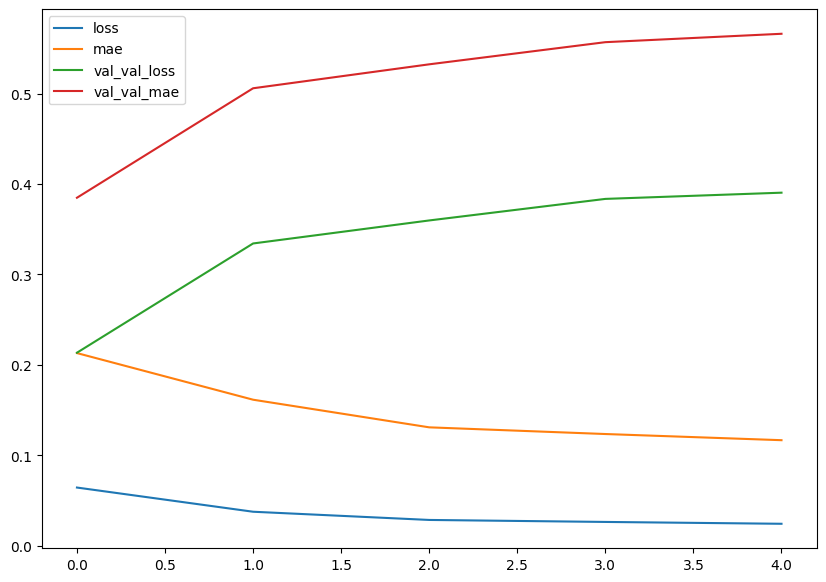

In [ ]:
pd.DataFrame(conv_ae_model_hist.history).plot(figsize=(10, 7))

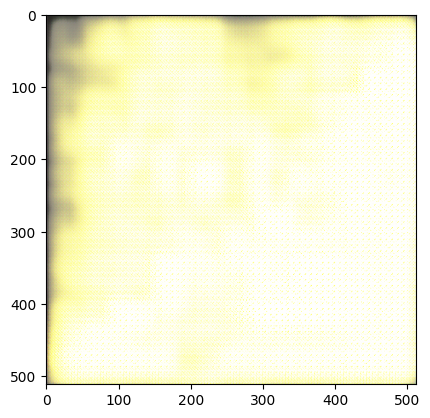

In [ ]:
plt.imshow(generated_test_data[0])

Reference:

https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit